### *Anaylse and Visuzalazation Sentiment Pattern in Socal Media:Twitter*

### *Dataset Introduction*
---
- This dataset contains tweets related to various topics or entities, along with sentiment analysis. The data is collected from Twitter and focuses on capturing user opinions and experiences shared via tweets. The tweets are categorized by sentiment, and each entry includes information about the entity being discussed. This type of dataset can be useful for analyzing public perception, tracking brand reputation, and identifying key topics or trends.
---

 ### *Import necessary libraries*

In [131]:
# Import necessary libraries
import pandas as pd  
import numpy as np  
import re                       # For regular expressions to clean text
import matplotlib.pyplot as plt
import seaborn as sns  
from wordcloud import WordCloud  # For generating word clouds from text data
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import warnings                        # For handling warnings in the code
warnings.filterwarnings("ignore") 

### *Load the dataset*

In [132]:
# Load the dataset without headers
sentiment= pd.read_csv('Twitter.csv', header=None)

# Assign column names manually
sentiment.columns = ['Tweet_id','Entity', 'Sentiment',  'Tweet_Text']

# Show the first few rows with the new column names
sentiment.head()

,Tweet_id,Entity,Sentiment,Tweet_Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


#### *Columns description*
*`Tweet ID:`*
    Description: A unique identifier assigned to each tweet. This ID is essential for referencing individual tweets within the dataset and for linking them to other relevant data if needed (e.g., replies, retweets).

*`Sentiment:`*
    Description: The sentiment classification of the tweet, which can typically be Positive, Negative, or Neutral. This sentiment is usually determined through `natural language processing (NLP)` techniques to understand the general emotion conveyed in the tweet.

*`Entity:`*
    Description: The entity or brand being discussed in the tweet. This could refer to a company, product, or any other notable subject being mentioned or referenced. For example, the entity might be "Borderlands" or "Madden NFL" if the tweet is discussing a specific video game.

*`Tweet Text:`*
    Description: The full text of the tweet, which contains the user's opinion, feedback, or statement. This column allows us to perform detailed analysis, such as extracting specific keywords or phrases associated with particular sentiments or entities.

### *Data Cleaning*

In [133]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tweet_id    74682 non-null  int64 
 1   Entity      74682 non-null  object
 2   Sentiment   74682 non-null  object
 3   Tweet_Text  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


#### *Observations*
---
- The dataset contains:`74682` enties in total.

- While it contains four colomns :`Tweet_id`, ` Entity`,`Sentiment` and `Tweet_Text `.

- There is missing values in  `Tweet Text ` have  `73,996 non-null values.`

---


### *Handling Missing Values*

In [134]:
# Remove rows with missing 'Tweet Text'
sentiment = sentiment.dropna(subset=['Tweet_Text'])

##### *Checking after dropping the coloumn*

In [135]:
# Verify the result by checking the data again
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tweet_id    73996 non-null  int64 
 1   Entity      73996 non-null  object
 2   Sentiment   73996 non-null  object
 3   Tweet_Text  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


#### *Descrption* 
- `Reasonablly minimal Data Loss:`
With only 686 missing values out of 74,682 rows, removing these rows has a minimal impact on the overall dataset size. The loss is small compared to the total amount of data, ensuring that the analysis will still be representative.
- filling with` unkown` will lead to misinformation that when anaylizing later will describe as` unkown `comment.



#### Checking for Duplicates

In [136]:
# Check if there are any duplicate rows
print(f'Duplicated Values:', sentiment.duplicated().sum())

Duplicated Values: 2341


####  Dropping Duplicate Rows

In [137]:
# Drop duplicate rows from the DataFrame
sentiment.drop_duplicates(inplace=True)


##### *Confirmation*

In [138]:
sentiment.duplicated().sum()

0

### *Cleaning the Tweet_Text*

---
- Tweets are typically written informally, and they may contain elements `(such as URLs, mentions, hashtags, or special characters)` that are not useful or might even interfere with the analysis of sentiment or key words. Cleaning the text ensures that we're working with a consistent format that focuses on the actual words , which improves the accuracy of sentiment analysis and other text-based tasks.
---

In [139]:
# Function to clean text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove mentions (e.g., @username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove special characters and numbers, keeping only alphabets and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    return text

# Apply the cleaning function and update the existing 'Tweet_Text' column
sentiment['Tweet_Text'] = sentiment['Tweet_Text'].apply(lambda x: clean_text(str(x)))

# Display the last 10 rows to confirm the updates
sentiment.tail(10)


,Tweet_id,Entity,Sentiment,Tweet_Text
74672,9199,Nvidia,Positive,let no elite go unnoticed nvidia highlights au...
74673,9199,Nvidia,Positive,let no elim go unnoticed nvidia highlights aut...
74674,9199,Nvidia,Positive,let a no information elim that go unnoticed nv...
74675,9199,Nvidia,Positive,unk my elim be no nvidia highlights pictures r...
74676,9200,Nvidia,Positive,just realized the windows partition of my mac ...
74677,9200,Nvidia,Positive,just realized that the windows partition of my...
74678,9200,Nvidia,Positive,just realized that my mac window partition is ...
74679,9200,Nvidia,Positive,just realized the windows partition of my mac ...
74680,9200,Nvidia,Positive,just realized between the windows partition of...
74681,9200,Nvidia,Positive,just like the windows partition of my mac is l...


### *Sentiment Classification Using VADER's Compound Score*

In [140]:
# Step 3: Sentiment Analysis using VADER
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment
def get_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)['compound']
    if sentiment_score >= 0.05:
        return 'Positive'
    elif sentiment_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis to the cleaned tweet column
sentiment['Sentiment'] = sentiment['Tweet_Text'].apply(get_sentiment)

# Check the sentiment classification
sentiment['Sentiment'].value_counts()

Sentiment
Positive    32510
Negative    26591
Neutral     12554
Name: count, dtype: int64

#### *Visualization for Sentiment Distribution*

In [ ]:
# Calculate sentiment counts
sentiment_counts = sentiment['Sentiment'].value_counts()

# Convert the counts to a DataFrame for easier plotting with Seaborn
sentiment_counts_df = sentiment_counts.reset_index()
sentiment_counts_df.columns = ['Sentiment', 'Count']

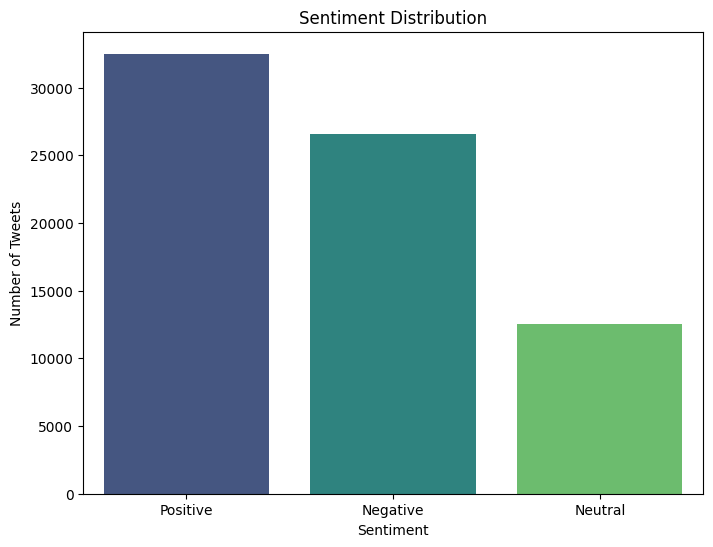

In [142]:
# Plot the sentiment distribution using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Count', data=sentiment_counts_df , palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.show()